In [4]:
import warnings

import pandas as pd
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

In [5]:
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
spark = SparkSession.builder.appName("modelovaniNehod").getOrCreate()

22/01/10 18:20:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/10 18:20:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
df = spark.read.parquet("data/4_processed")
df.limit(5).toPandas()

,features,label
0,"[104.52085919440314, 3.962358629522141, 0.0, 4...",1.0
1,"[104.52085919440314, 4.129996879232693, 0.0, 4...",0.0
2,"[104.52085919440314, 4.210006043867275, 0.0, 4...",0.0
3,"[104.52085919440314, 4.17952636210172, 0.0, 4....",1.0
4,"[105.53097940024936, 3.825200061577144, 0.0, 4...",0.0


In [49]:
with open('data/feature_list.txt', 'r') as f:
    feature_cols = f.read().splitlines()

# Split data

In [4]:
trainData, testData = df.orderBy(F.rand(seed=0)).randomSplit([0.7, 0.3], seed=0)
print("trainData count is {}, testDataCount is: {}".format(trainData.count(), testData.count()))

trainData count is 4150307, testDataCount is: 1781118


# Prepare estimators

In [28]:
stages = []

# DECISION TREE CLASSIFIER
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", predictionCol="DTprediction", rawPredictionCol="DTRawPrediction", probabilityCol="DTProbability")
stages.append(dt)

# RANDOM FOREST CLASSIFIER
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", predictionCol="RFprediction", rawPredictionCol="RFRawPrediction", probabilityCol="RFProbability", numTrees=10)
stages.append(rf)

# GBT CLASSIFIER
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", predictionCol="GBTprediction", maxIter=10)
stages.append(gbt)

# LOGISTIC REGRESSION
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="LRprediction", probabilityCol="LRProbability", rawPredictionCol="LRRawPrediction", family="binomial", threshold=0.5)
stages.append(lr)

# NAIVE BAYES
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol="features", labelCol="label", predictionCol="NBprediction", probabilityCol="NBProbability", rawPredictionCol="NBRawPprediction")
stages.append(nb)

# Predict

In [ ]:
pipeline = Pipeline(stages = stages)
predictionModel = pipeline.fit(trainData)
predictions = predictionModel.transform(testData)

# Evaluate

In [30]:
predictions.limit(5).toPandas()

,features,label,DTRawPrediction,DTProbability,DTprediction,RFRawPrediction,RFProbability,RFprediction,rawPrediction,probability,GBTprediction,LRRawPrediction,LRProbability,LRprediction,NBRawPprediction,NBProbability,NBprediction
0,"[102.92593255359333, 3.897589305770337, 0.0, 4...",1.0,"[14114.0, 86365.0]","[0.14046716229261835, 0.8595328377073816]",1.0,"[2.2149286649333364, 7.785071335066663]","[0.22149286649333363, 0.7785071335066662]",1.0,"[-0.8734259294937008, 0.8734259294937008]","[0.14844471073298196, 0.8515552892670181]",1.0,"[-1.9354780254956232, 1.9354780254956232]","[0.1261454843135585, 0.8738545156864415]",1.0,"[-286.1314664020237, -285.86528232354163]","[0.43384413696959273, 0.5661558630304073]",1.0
1,"[102.92593255359333, 3.9737885101842245, 0.0, ...",0.0,"[14114.0, 86365.0]","[0.14046716229261835, 0.8595328377073816]",1.0,"[2.6836983663611145, 7.3163016336388855]","[0.26836983663611147, 0.7316301633638885]",1.0,"[-0.3796607285598292, 0.3796607285598292]","[0.3187936033394362, 0.6812063966605638]",1.0,"[-1.006944896450669, 1.006944896450669]","[0.26757816491949965, 0.7324218350805003]",1.0,"[-289.50895111468884, -289.35612038857244]","[0.4618665139786839, 0.538133486021316]",1.0
2,"[102.92593255359333, 4.046177754377418, 0.0, 4...",0.0,"[169423.0, 29364.0]","[0.8522841030852119, 0.1477158969147882]",0.0,"[7.610091171949234, 2.389908828050766]","[0.7610091171949234, 0.23899088280507658]",0.0,"[1.0629609199150238, -1.0629609199150238]","[0.8933972326492033, 0.10660276735079666]",0.0,"[2.4098706234398897, -2.4098706234398897]","[0.9175768977116707, 0.08242310228832928]",0.0,"[-300.06836830705487, -300.0993298184919]","[0.5077397595815499, 0.49226024041845]",0.0
3,"[102.92593255359333, 4.084277356584361, 0.0, 4...",0.0,"[291418.0, 33936.0]","[0.8956951505129797, 0.10430484948702029]",0.0,"[8.15101955507691, 1.8489804449230898]","[0.815101955507691, 0.18489804449230898]",0.0,"[1.2420652235828653, -1.2420652235828653]","[0.923021789995254, 0.07697821000474603]",0.0,"[4.758539429078924, -4.758539429078924]","[0.9914948292355189, 0.008505170764481096]",0.0,"[-313.83150295442186, -313.98401598458383]","[0.5380545230583711, 0.46194547694162885]",0.0
4,"[102.92593255359333, 4.084277356584361, 0.0, 4...",0.0,"[169423.0, 29364.0]","[0.8522841030852119, 0.1477158969147882]",0.0,"[7.610091171949234, 2.389908828050766]","[0.7610091171949234, 0.23899088280507658]",0.0,"[1.0629609199150238, -1.0629609199150238]","[0.8933972326492033, 0.10660276735079666]",0.0,"[2.414360257706594, -2.414360257706594]","[0.9179158107089528, 0.08208418929104722]",0.0,"[-317.9183866624868, -317.96171629268974]","[0.5108307130873814, 0.4891692869126187]",0.0


In [31]:
def get_metrics(prefix):
    predictionAndTarget = predictions.select(['label', prefix + 'prediction'])

    # Create both evaluators
    metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))
    metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

    acc = metrics_multi.accuracy
    f1 = metrics_multi.fMeasure(1.0)
    precision = metrics_multi.precision(1.0)
    recall = metrics_multi.recall(1.0)
    auc = metrics_binary.areaUnderROC
    
    return dict(
        acc = acc,
        f1 = f1,
        precision = precision,
        recall = recall,
        auc = auc
    )

In [32]:
estimators = ['DT', 'RF', 'GBT', 'LR', 'NB']
performances = dict()

for estimator in estimators:
    print(estimator)
    performances[estimator] = get_metrics(estimator)

DT


RF


GBT


LR


NB


In [33]:
pd.DataFrame.from_dict(performances).T.sort_values('f1', ascending=False)

,acc,f1,precision,recall,auc
LR,0.779064,0.789827,0.794493,0.785215,0.778690
GBT,0.765141,0.777575,0.785662,0.769653,0.764818
RF,0.742364,0.759276,0.777601,0.741795,0.742424
NB,0.681694,0.749676,0.912191,0.636311,0.726736
DT,0.739318,0.733386,0.686170,0.787581,0.743283


## Logistic regression coefficients

In [ ]:
lrModel = lr.fit(trainData)

In [41]:
predictors = pd.DataFrame.from_dict(dict(zip(feature_cols, lrModel.coefficients)), orient='index').sort_values(0, ascending=False)
predictors

,0
Elo hráče před,2.770872
Max elo,0.456275
Rok narození,0.056394
Max elo_soupeř,0.038403
Elo nejlepšího poraženého soupeře,0.029778
Hráč je žena,0.003589
Den v týdnu,0.001842
Víkend,0.000000
obdobi,0.000000
Soupeř je žena,-0.000492


In [68]:
print(f"The most significant predictors are: {predictors.index[0]}, {predictors.index[1]} and {predictors.index[-1]}")

The most significant predictors are: Elo hráče před, Max elo and Elo soupeře před


<hr>

# Neural networks (Keras)

In [23]:
from elephas.ml_model import ElephasEstimator

from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping

In [8]:
input_dim = len(df.select("features").first()[0])
input_dim

13

In [40]:
model = Sequential([
    Dense(64, activation="relu", input_shape=(input_dim,)),
    Dropout(0.4),

    Dense(32, activation="relu"),
    Dropout(0.2),
    
    Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy",
             optimizer="adam")

adam = optimizers.Adam(lr=0.01)
adam_conf = optimizers.serialize(adam)
es = EarlyStopping(patience=5, restore_best_weights=True)

In [22]:
# Initialize Elephas Spark ML Estimator
elephas = ElephasEstimator()
elephas.set_keras_model_config(model.to_json())
elephas.set_optimizer_config(adam_conf)
elephas.set_mode("synchronous")
elephas.set_loss("binary_crossentropy")
elephas.set_metrics(['acc'])
elephas.setFeaturesCol("features")
elephas.setLabelCol("label")
elephas.set_epochs(15)
elephas.set_batch_size(64)
elephas.set_num_workers(2)
elephas.set_verbosity(0)
elephas.set_validation_split(0.1)
elephas.set_categorical_labels(False)
elephas.set_nb_classes(1)

ElephasEstimator_8dcc9fd86f06

In [23]:
pipeline = Pipeline(stages=[elephas])
fitted_pipeline = pipeline.fit(trainData.sample(fraction=0.5))

>>> Fit model


2021-12-23 14:14:42.116191: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 14:14:42.116200: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


>>> Synchronous training complete.


In [24]:
prediction = fitted_pipeline.transform(testData.sample(fraction=0.01))
pnl = prediction.select("label", "prediction")
pnl.limit(10).toPandas()

,label,prediction
0,1.0,[0.544213593006134]
1,0.0,[0.5433858036994934]
2,1.0,[0.5444167852401733]
3,1.0,[0.5443340539932251]
4,1.0,[0.545165479183197]
5,0.0,[0.5433814525604248]
6,1.0,[0.5502046346664429]
7,1.0,[0.5453768968582153]
8,0.0,[0.5428350567817688]
9,1.0,[0.5460066795349121]


In [25]:
label_and_preds = prediction.rdd.map(lambda row: (row['label'], row['prediction'][0]))

In [26]:
MulticlassMetrics(label_and_preds).accuracy

2021-12-23 14:20:25.688655: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 14:20:28.579274: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 14:20:28.639464: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

0.0

<hr>

## Neural networks with Keras & Pandas

In [53]:
N = 500000

In [55]:
import numpy as np

df = pd.read_parquet('data/4_processed')[:N]
df['expanded'] = df['features'].apply(pd.Series)['values']
arr = np.array(df.expanded.tolist())
res_df = pd.DataFrame(columns=feature_cols)
res_df[res_df.columns] = arr

In [57]:
y = df['label']
X = res_df

In [58]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3)

In [60]:
model = Sequential([
    Dense(64, activation="relu", input_shape=(input_dim,)),
    Dropout(0.4),

    Dense(32, activation="relu"),
    Dropout(0.2),
    
    Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam")
adam = optimizers.Adam(lr=0.01)
adam_conf = optimizers.serialize(adam)
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=25, callbacks=[es])

Epoch 1/25
10938/10938 [==============================] - 16s 1ms/step - loss: 0.6786 - val_loss: 0.5432
Epoch 2/25
10938/10938 [==============================] - 15s 1ms/step - loss: 0.5623 - val_loss: 0.5369
Epoch 3/25
10938/10938 [==============================] - 16s 1ms/step - loss: 0.5525 - val_loss: 0.5149
Epoch 4/25
10938/10938 [==============================] - 14s 1ms/step - loss: 0.5425 - val_loss: 0.5267
Epoch 5/25
10938/10938 [==============================] - 15s 1ms/step - loss: 0.5387 - val_loss: 0.5418
Epoch 6/25
10938/10938 [==============================] - 14s 1ms/step - loss: 0.5377 - val_loss: 0.5601
Epoch 7/25
10938/10938 [==============================] - 15s 1ms/step - loss: 0.5354 - val_loss: 0.5267
Epoch 8/25
10938/10938 [==============================] - 15s 1ms/step - loss: 0.5334 - val_loss: 0.5178


<AxesSubplot:>

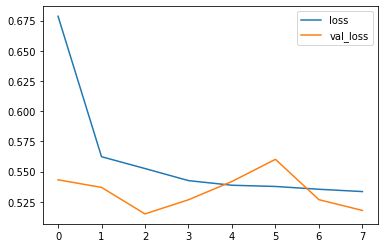

In [61]:
pd.DataFrame(history.history).plot()

In [62]:
preds = model.predict(X_test)
from sklearn.metrics import accuracy_score as acc
acc(y_test, np.round(preds))

0.7577933333333333